In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
from keras.layers import *
from keras import backend as K
from keras.models import Model
import imageio,os
from keras.datasets import mnist
from keras.utils.vis_utils import plot_model
import preprocess
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
# batch_size=100
latent_dim=10
# epochs=5
num_classes=10
img_dim=28
filters=16
intermediate_dim=256


batch_size =32 #
epochs = 5
# num_classes =7   # 类别
# length =16384   # 信号长度  16384=128*128
BatchNorm = True  # 是否批量归一化
number = 3000  # 每类样本的数量  1000:0.32,  10000:0.68,  20000:0.7105   30000:81
normal = True  # 是否标准化
rate = [0.8, 0.1, 0.1]  # 训练集验证集测试集划分比例,之和为1

In [3]:
# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [4]:
print(x_train.shape)
print(y_train_.shape)
y_train_

(60000, 28, 28, 1)
(60000,)


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

### 加载故障数据

In [5]:
# path_training = r"F:\paderborn dataset\start_data\training_dataset\N09_M07_F10\all"
# path_testing = r"F:\paderborn dataset\start_data\training_dataset\N09_M07_F10\all"
# x_train1, y_train1, x_valid1, y_valid1, x_test1, y_test1=preprocess.prepro(d_path=path_training,d_path1=path_testing, length=length,number=number,normal=normal,rate=rate,enc=True, enc_step=28)


# x_train = x_train.reshape((-1, img_dim, img_dim, 1))
# x_test = x_test.reshape((-1, img_dim, img_dim, 1))
# print(data_in.shape)
# plot_data=data_in.values[2000:6096]
# plt.plot(range(4096),plot_data)
# plt.show()
# data_in.head()


In [6]:
# 实验
# gg=np.array([[1,2,3,4,5,6,7,8,9],[11,12,13,14,15,16,17,18,19]])
# print(gg.shape)
# gg.reshape(2,3,3)
# (2, 9)
# array([[[ 1,  2,  3],
#         [ 4,  5,  6],
#         [ 7,  8,  9]],

#        [[11, 12, 13],
#         [14, 15, 16],
#         [17, 18, 19]]])

# print(x_train.shape)
# print(x_test.shape)
# print(x_valid.shape)
# print(y_train)
# print('*'*50)
# x_train = x_train.reshape((-1, img_dim, img_dim, 1))
# x_valid = x_valid.reshape((-1, img_dim, img_dim, 1))
# x_test = x_test.reshape((-1, img_dim, img_dim, 1))
# print(x_train.shape)
# print(x_test.shape)
# print(x_valid.shape)

### 卷积

In [7]:
# 搭建模型
x = Input(shape=(img_dim, img_dim, 1))
h = x
print("==========开始训练===========")
filters *= 2
for i in range(2):
    filters *= 2
    h = Conv2D(filters=filters,kernel_size=3,strides=2,padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(filters=filters,kernel_size=3,strides=1,padding='same')(h)
    h = LeakyReLU(0.2)(h)

==========开始训练===========
Instructions for updating:
Colocations handled automatically by placer.


### 特征拾取

In [8]:
h4=h
h = LeakyReLU(0.2)(h4)
h_shape = K.int_shape(h)[1:]
h = Flatten()(h)
z_mean = Dense(latent_dim)(h) # p(z|x)的均值
z_log_var = Dense(latent_dim)(h) # p(z|x)的方差
encoder = Model(x, z_mean) # 通常认为z_mean就是所需的隐变量编码
z = Input(shape=(latent_dim,))
h = z
h = Dense(np.prod(h_shape))(h)
h = Reshape(h_shape)(h)

### 反卷积

In [9]:

for i in range(2):
    h = Conv2DTranspose(filters=filters,kernel_size=3,strides=1,padding='same')(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2DTranspose(filters=filters,kernel_size=3,strides=2,padding='same')(h)
    h = LeakyReLU(0.2)(h)
    filters //= 2

In [10]:
x_recon = Conv2DTranspose(filters=1,kernel_size=3,activation='sigmoid',padding='same')(h)

In [11]:
decoder = Model(z, x_recon) # 解码器
generator = decoder

z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)
classfier = Model(z, y) # 隐变量分类器

### 重参数技巧

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classfier(z)

In [13]:
class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',shape=(self.num_classes, latent_dim),initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

### 损失函数

In [14]:
gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)


# 建立模型
vae = Model(x, [x_recon, z_prior_mean, y])

# 下面一大通都是为了定义loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 2.5 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0)
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0)
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss)


vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.fit(x_train,shuffle=True,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None),verbose=2)
plot_model(model=vae, to_file='vae_keras_cluster.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [17]:
means = K.eval(gaussian.mean)
x_train_encoded = encoder.predict(x_train)
y_train_pred = classfier.predict(x_train_encoded).argmax(axis=1)
x_test_encoded = encoder.predict(x_test)
y_test_pred = classfier.predict(x_test_encoded).argmax(axis=1)

In [24]:
def cluster_sample(path, category=0):
    """观察被模型聚为同一类的样本
    """
    n = 8
    print('*'*50)
    figure = np.zeros((img_dim * n, img_dim * n))
    idxs = np.where(y_train_pred == category)[0]
    print(idxs.shape)
    print('*'*50)
    for i in range(n):
        for j in range(n):
            digit = x_train[np.random.choice(idxs)]
            digit = digit.reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)


def random_sample(path, category=0, std=1):
    """按照聚类结果进行条件随机生成
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    for i in range(n):
        for j in range(n):
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape)) * std + means[category]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)


if not os.path.exists('samples'):
    os.mkdir('samples')

for i in range(10):
    cluster_sample(u'samples/聚类类别_%s.png' % i, i)
    random_sample(u'samples/类别采样_%s.png' % i, i)
    
right = 0.
for i in range(10):
    print('%'*50)
    print(y_train_)
    print('%'*50)
    _ = np.bincount(y_train_[y_train_pred == i])
    right += _.max()

print ('train acc: %s' % (right / len(y_train_)))


right = 0.
for i in range(10):
    _ = np.bincount(y_test_[y_test_pred == i])
    right += _.max()

print ('test acc: %s' % (right / len(y_test_)))

**************************************************
(5043,)
**************************************************


**************************************************
(5413,)
**************************************************


**************************************************
(6315,)
**************************************************


**************************************************
(5526,)
**************************************************


**************************************************
(5448,)
**************************************************


**************************************************
(6705,)
**************************************************


**************************************************
(6613,)
**************************************************


**************************************************
(6711,)
**************************************************


**************************************************
(6080,)
**************************************************


**************************************************
(6146,)
**************************************************


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[5 0 4 ... 5 6 8]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

## 实验环节

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
784
Epoch: 1/3... Training loss: 0.7188
Epoch: 1/3... Training loss: 0.6207
Epoch: 1/3... Training loss: 0.5289
Epoch: 1/3... Training loss: 0.4333
Epoch: 1/3... Training loss: 0.3648
Epoch: 1/3... Training loss: 0.3221
Epoch: 1/3... Training loss: 0.3028
Epoch: 1/3... Training loss: 0.3092
Epoch: 1/3... Training loss: 0.2991
Epoch: 1/3... Training loss: 0.3235
Epoch: 1/3... Training loss: 0.3082
Epoch: 1/3... Training loss: 0.2897
Epoch: 1/3... Training loss: 0.2955
Epoch: 1/3... Training loss: 0.2918
Epoch: 1/3... Training loss: 0.2789
Epoch: 1/3... Training loss: 0.2849
Epoch: 1/3... Training loss: 0.2822
Epoch: 1/3... Training loss: 0.2844
Epoch: 1/3... Training loss: 0.2736
Epoch: 1/3... Training loss: 0.2740
Epoch: 1/3... Training loss: 0.2641
Epoch: 1/3... Training loss: 0.2735
Epoch: 1/3

Epoch: 1/3... Training loss: 0.1927
Epoch: 1/3... Training loss: 0.1908
Epoch: 1/3... Training loss: 0.1935
Epoch: 1/3... Training loss: 0.1946
Epoch: 1/3... Training loss: 0.1965
Epoch: 1/3... Training loss: 0.1947
Epoch: 1/3... Training loss: 0.1917
Epoch: 1/3... Training loss: 0.1911
Epoch: 1/3... Training loss: 0.1959
Epoch: 1/3... Training loss: 0.1901
Epoch: 1/3... Training loss: 0.1902
Epoch: 1/3... Training loss: 0.1995
Epoch: 1/3... Training loss: 0.1893
Epoch: 1/3... Training loss: 0.1922
Epoch: 1/3... Training loss: 0.1862
Epoch: 1/3... Training loss: 0.1906
Epoch: 1/3... Training loss: 0.1875
Epoch: 1/3... Training loss: 0.1877
Epoch: 1/3... Training loss: 0.1906
Epoch: 1/3... Training loss: 0.1995
Epoch: 1/3... Training loss: 0.1916
Epoch: 1/3... Training loss: 0.1931
Epoch: 1/3... Training loss: 0.1952
Epoch: 1/3... Training loss: 0.1913
Epoch: 1/3... Training loss: 0.1939
Epoch: 1/3... Training loss: 0.1918
Epoch: 1/3... Training loss: 0.1939
Epoch: 1/3... Training loss:

Epoch: 1/3... Training loss: 0.1807
Epoch: 1/3... Training loss: 0.1739
Epoch: 1/3... Training loss: 0.1844
Epoch: 1/3... Training loss: 0.1789
Epoch: 1/3... Training loss: 0.1820
Epoch: 1/3... Training loss: 0.1798
Epoch: 1/3... Training loss: 0.1756
Epoch: 1/3... Training loss: 0.1769
Epoch: 1/3... Training loss: 0.1808
Epoch: 1/3... Training loss: 0.1812
Epoch: 1/3... Training loss: 0.1765
Epoch: 1/3... Training loss: 0.1740
Epoch: 2/3... Training loss: 0.1824
Epoch: 2/3... Training loss: 0.1830
Epoch: 2/3... Training loss: 0.1738
Epoch: 2/3... Training loss: 0.1787
Epoch: 2/3... Training loss: 0.1786
Epoch: 2/3... Training loss: 0.1815
Epoch: 2/3... Training loss: 0.1836
Epoch: 2/3... Training loss: 0.1801
Epoch: 2/3... Training loss: 0.1827
Epoch: 2/3... Training loss: 0.1829
Epoch: 2/3... Training loss: 0.1772
Epoch: 2/3... Training loss: 0.1779
Epoch: 2/3... Training loss: 0.1838
Epoch: 2/3... Training loss: 0.1789
Epoch: 2/3... Training loss: 0.1762
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1707
Epoch: 2/3... Training loss: 0.1797
Epoch: 2/3... Training loss: 0.1645
Epoch: 2/3... Training loss: 0.1740
Epoch: 2/3... Training loss: 0.1723
Epoch: 2/3... Training loss: 0.1738
Epoch: 2/3... Training loss: 0.1700
Epoch: 2/3... Training loss: 0.1699
Epoch: 2/3... Training loss: 0.1708
Epoch: 2/3... Training loss: 0.1719
Epoch: 2/3... Training loss: 0.1796
Epoch: 2/3... Training loss: 0.1740
Epoch: 2/3... Training loss: 0.1679
Epoch: 2/3... Training loss: 0.1724
Epoch: 2/3... Training loss: 0.1631
Epoch: 2/3... Training loss: 0.1781
Epoch: 2/3... Training loss: 0.1785
Epoch: 2/3... Training loss: 0.1766
Epoch: 2/3... Training loss: 0.1695
Epoch: 2/3... Training loss: 0.1714
Epoch: 2/3... Training loss: 0.1655
Epoch: 2/3... Training loss: 0.1650
Epoch: 2/3... Training loss: 0.1744
Epoch: 2/3... Training loss: 0.1678
Epoch: 2/3... Training loss: 0.1729
Epoch: 2/3... Training loss: 0.1671
Epoch: 2/3... Training loss: 0.1718
Epoch: 2/3... Training loss:

Epoch: 2/3... Training loss: 0.1676
Epoch: 2/3... Training loss: 0.1661
Epoch: 2/3... Training loss: 0.1720
Epoch: 3/3... Training loss: 0.1640
Epoch: 3/3... Training loss: 0.1699
Epoch: 3/3... Training loss: 0.1709
Epoch: 3/3... Training loss: 0.1672
Epoch: 3/3... Training loss: 0.1660
Epoch: 3/3... Training loss: 0.1617
Epoch: 3/3... Training loss: 0.1606
Epoch: 3/3... Training loss: 0.1682
Epoch: 3/3... Training loss: 0.1631
Epoch: 3/3... Training loss: 0.1660
Epoch: 3/3... Training loss: 0.1651
Epoch: 3/3... Training loss: 0.1702
Epoch: 3/3... Training loss: 0.1624
Epoch: 3/3... Training loss: 0.1680
Epoch: 3/3... Training loss: 0.1689
Epoch: 3/3... Training loss: 0.1671
Epoch: 3/3... Training loss: 0.1706
Epoch: 3/3... Training loss: 0.1653
Epoch: 3/3... Training loss: 0.1689
Epoch: 3/3... Training loss: 0.1740
Epoch: 3/3... Training loss: 0.1707
Epoch: 3/3... Training loss: 0.1705
Epoch: 3/3... Training loss: 0.1677
Epoch: 3/3... Training loss: 0.1720
Epoch: 3/3... Training loss:

Epoch: 3/3... Training loss: 0.1597
Epoch: 3/3... Training loss: 0.1729
Epoch: 3/3... Training loss: 0.1661
Epoch: 3/3... Training loss: 0.1638
Epoch: 3/3... Training loss: 0.1661
Epoch: 3/3... Training loss: 0.1680
Epoch: 3/3... Training loss: 0.1658
Epoch: 3/3... Training loss: 0.1648
Epoch: 3/3... Training loss: 0.1669
Epoch: 3/3... Training loss: 0.1728
Epoch: 3/3... Training loss: 0.1666
Epoch: 3/3... Training loss: 0.1593
Epoch: 3/3... Training loss: 0.1659
Epoch: 3/3... Training loss: 0.1667
Epoch: 3/3... Training loss: 0.1720
Epoch: 3/3... Training loss: 0.1691
Epoch: 3/3... Training loss: 0.1777
Epoch: 3/3... Training loss: 0.1710
Epoch: 3/3... Training loss: 0.1673
Epoch: 3/3... Training loss: 0.1598
Epoch: 3/3... Training loss: 0.1593
Epoch: 3/3... Training loss: 0.1664
Epoch: 3/3... Training loss: 0.1642
Epoch: 3/3... Training loss: 0.1621
Epoch: 3/3... Training loss: 0.1672
Epoch: 3/3... Training loss: 0.1625
Epoch: 3/3... Training loss: 0.1668
Epoch: 3/3... Training loss:

Epoch: 3/3... Training loss: 0.1653


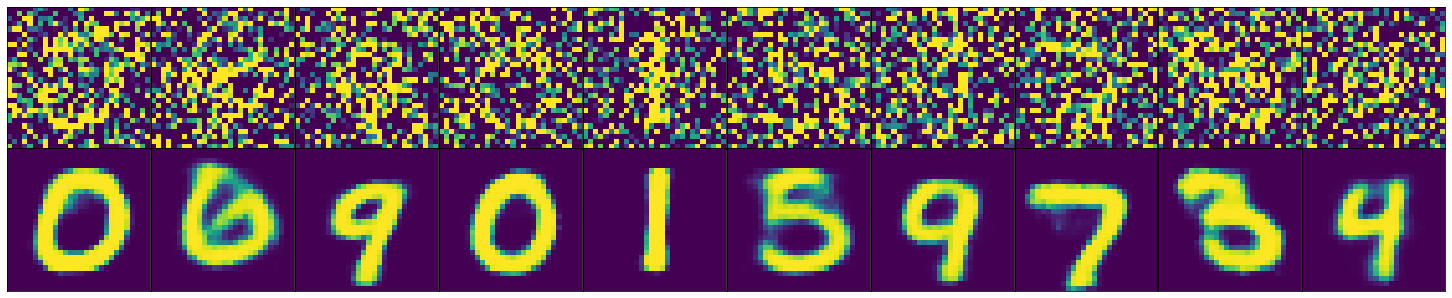

In [13]:
# -*- coding: utf-8 -*-
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from keras.optimizers import adadelta
mnist = input_data.read_data_sets('MNIST_data', validation_size=0, one_hot= False)

hidden_units = 32
image_size = mnist.train.images.shape[1]
print(image_size)

# Input
inputs_ = tf.placeholder(tf.float32,[None,image_size],name='input_')
targets_ = tf.placeholder(tf.float32,[None,image_size],name='targets_')

# hidden
hidden_layer = tf.layers.dense(inputs_,image_size,activation=tf.nn.relu)

# Logits&outputs
logits_ = tf.layers.dense(hidden_layer, image_size, activation=None)
outputs_ = tf.sigmoid(logits_,name='outputs_')

# loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_)
cost = tf.reduce_mean(loss)

# Optimizer
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

sess = tf.Session()
noise_factor =1
epochs = 3
batch_size = 128
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0]
        # 加入噪声
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        batch_cost, _ = sess.run([cost, optimizer],
                                 feed_dict={inputs_: noisy_imgs,
                                            targets_: batch[0]})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))


fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
imgs = mnist.test.images[10:20]
# 加入噪声
noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0.0, 1.0)

reconstructed = sess.run(outputs_, feed_dict={inputs_: imgs})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)